In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17930 sha256=f233729d794c0cc7cc87bdba85b922e84a3ce0bae3792aed11f327760a6c2224
  Stored in directory: /root/.cache/pip/wheels/b3/a3/76/3837f862d81a243763a3bc38d363603066dd5474e1c31dc5d6
Successfully built jcopdl


In [3]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders  

In [ ]:
input_folder ='/content/drive/MyDrive/Yoga-82/Yoga-82-refined/Yoga-82-refined-v2'

In [ ]:
splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Yoga-82/Yoga-82-refined/images", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) # default values

Copying files: 15583 files [03:50, 67.50 files/s]


In [5]:
bs = 32
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/drive/MyDrive/Yoga-82/Yoga-82-refined/images/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

val_set = datasets.ImageFolder("/content/drive/MyDrive/Yoga-82/Yoga-82-refined/images/val", transform=test_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/drive/MyDrive/Yoga-82/Yoga-82-refined/images/test", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True)

In [6]:
len(train_set), len(val_set), len(test_set)

(10871, 3088, 1624)

In [7]:
label2cat = train_set.classes
label2cat, len(label2cat)

(['Akarna_Dhanurasana',
  "Bharadvaja's_Twist_pose_or_Bharadvajasana_I_",
  'Boat_Pose_or_Paripurna_Navasana_',
  'Bound_Angle_Pose_or_Baddha_Konasana_',
  'Bow_Pose_or_Dhanurasana_',
  'Bridge_Pose_or_Setu_Bandha_Sarvangasana_',
  'Camel_Pose_or_Ustrasana_',
  'Cat_Cow_Pose_or_Marjaryasana_',
  'Chair_Pose_or_Utkatasana_',
  'Child_Pose_or_Balasana_',
  'Cobra_Pose_or_Bhujangasana_',
  'Cockerel_Pose',
  'Corpse_Pose_or_Savasana_',
  'Cow_Face_Pose_or_Gomukhasana_',
  'Crane_(Crow)_Pose_or_Bakasana_',
  'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_',
  'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_',
  'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_',
  'Eagle_Pose_or_Garudasana_',
  'Eight-Angle_Pose_or_Astavakrasana_',
  'Extended_Puppy_Pose_or_Uttana_Shishosana_',
  'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_',
  'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_',
  'Feathered_Peacock_Pose_or_Pincha_Mayurasana_',
  'Firefly_Pose_or_Tittibhasana_',
  'Fi

In [8]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([32, 3, 224, 224])

In [9]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [10]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

In [11]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 3.2060 | Test_cost  = 2.4516 | Train_score = 0.2583 | Test_score = 0.4067 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 2.0854 | Test_cost  = 2.1271 | Train_score = 0.4815 | Test_score = 0.4488 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.7488 | Test_cost  = 1.9192 | Train_score = 0.5486 | Test_score = 0.4880 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.5364 | Test_cost  = 1.8315 | Train_score = 0.5941 | Test_score = 0.5214 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.4178 | Test_cost  = 1.8323 | Train_score = 0.6256 | Test_score = 0.5091 |
==> EarlyStop patience =  1 | Best test_score: 0.5214


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.3201 | Test_cost  = 1.7840 | Train_score = 0.6402 | Test_score = 0.5275 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.2546 | Test_cost  = 1.7997 | Train_score = 0.6578 | Test_score = 0.5194 |
==> EarlyStop patience =  1 | Best test_score: 0.5275


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.1971 | Test_cost  = 1.7772 | Train_score = 0.6655 | Test_score = 0.5350 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.1378 | Test_cost  = 1.7554 | Train_score = 0.6791 | Test_score = 0.5379 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.1065 | Test_cost  = 1.7397 | Train_score = 0.6903 | Test_score = 0.5385 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
AssertionError: can only test a child process    
self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProce

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.0439 | Test_cost  = 1.7247 | Train_score = 0.7036 | Test_score = 0.5473 |


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1.0375 | Test_cost  = 1.7675 | Train_score = 0.7070 | Test_score = 0.5450 |
==> EarlyStop patience =  1 | Best test_score: 0.5473


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train:   0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5ae164040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Val:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.9905 | Test_cost  = 1.7876 | Train_score = 0.7160 | Test_score = 0.5392 |
==> EarlyStop patience =  2 | Best test_score: 0.5473
==> Execute Early Stopping at epoch: 13 | Best test_score: 0.5473
==> Best model is saved at model


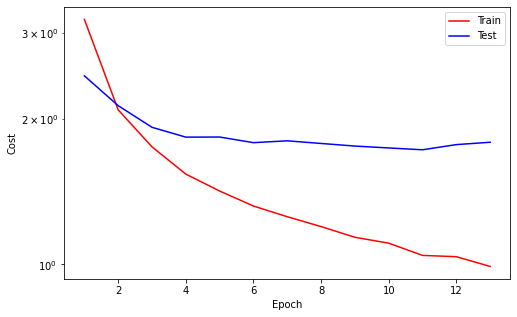

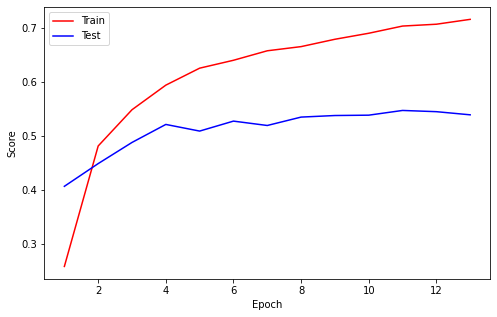

In [13]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

# Predict

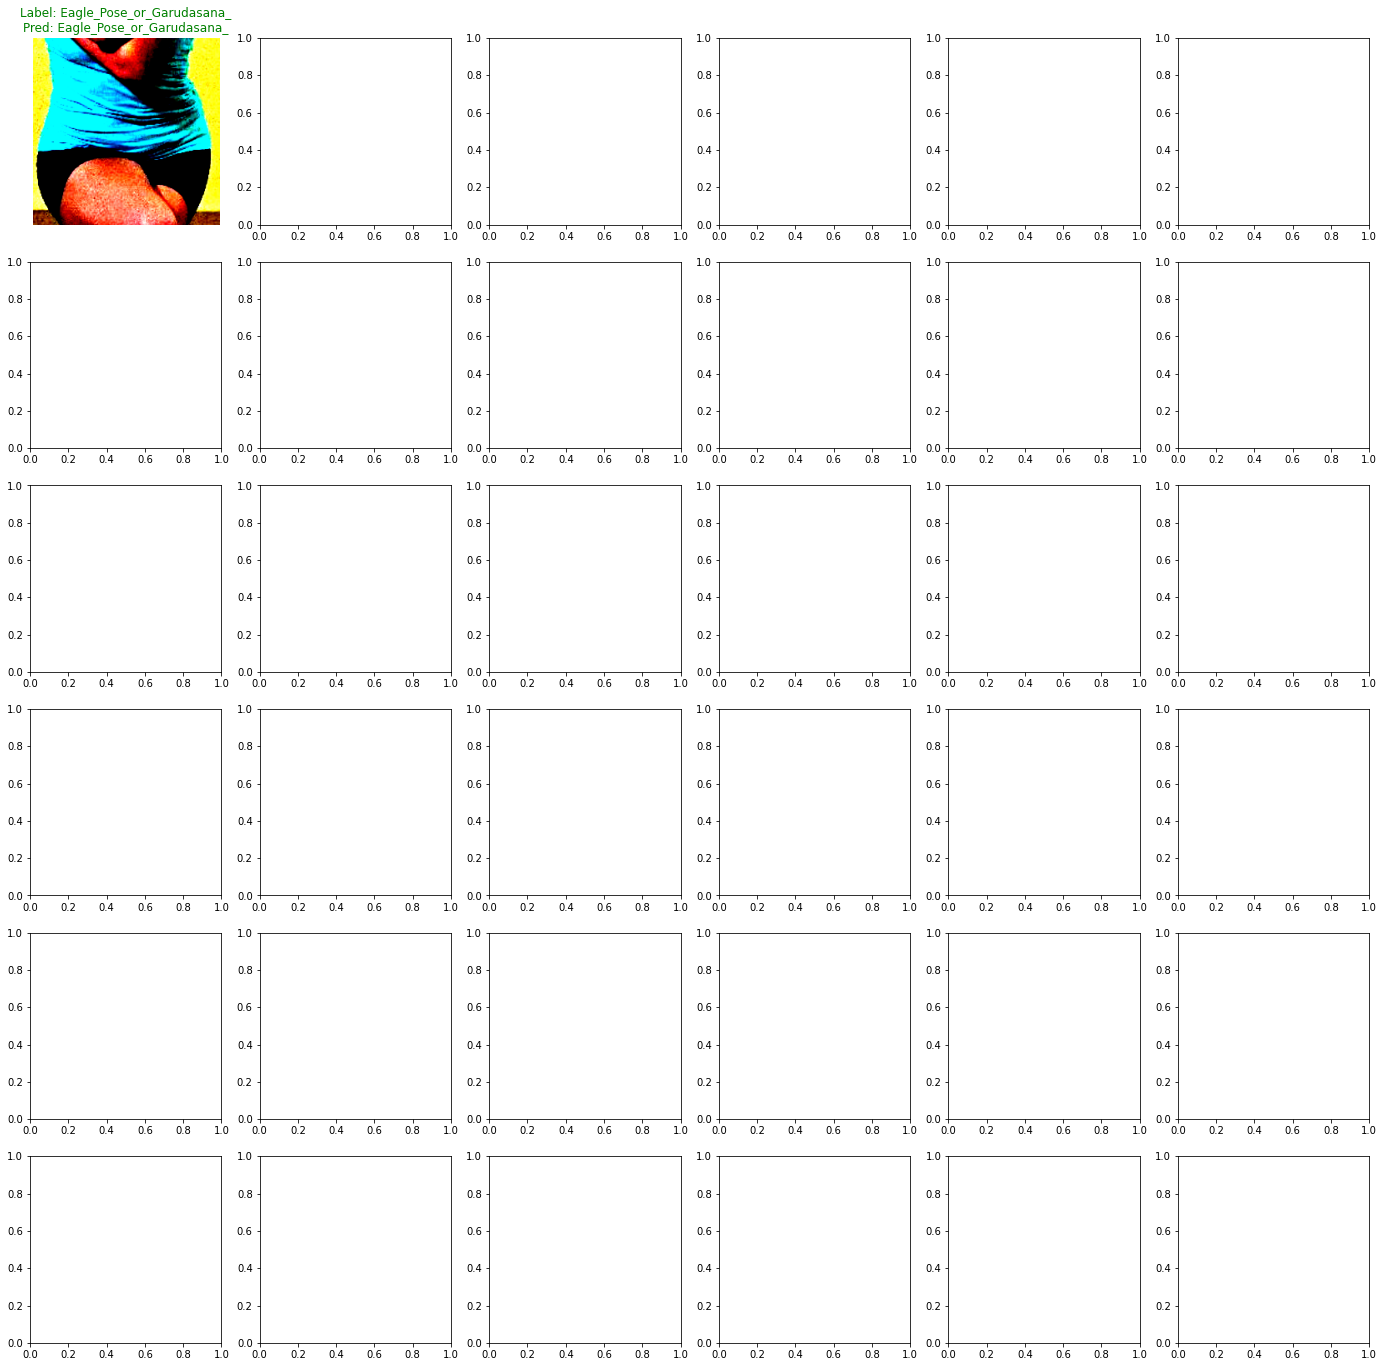

In [14]:
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");

# Test Score

In [15]:
accuracy = []
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    if(target == preds):
      acc = 1
    else: acc = 0
    accuracy.append(acc)
accuracy = np.array(accuracy)
accuracy.mean()

0.5320197044334976